In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [0]:
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os, shutil # Library for navigating files
from google.colab import drive # Library to mount google drives
import pandas as pd
import tensorflow as tf
from sklearn import metrics

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


***After Epoch: 100  |Test accuracy =  0.9107567 ****
***After Epoch: 200  |Test accuracy =  0.93383104 ****
***After Epoch: 300  |Test accuracy =  0.92941976 ****
***After Epoch: 400  |Test accuracy =  0.9297591 ****
***After Epoch: 500  |Test accuracy =  0.93417037 ****
***After Epoch: 600  |Test accuracy =  0.9287411 ****
***After Epoch: 700  |Test accuracy =  0.93383104 ****
***After Epoch: 800  |Test accuracy =  0.9331524 ****
***After Epoch: 900  |Test accuracy =  0.93688494 ****
***After Epoch: 1000  |Test accuracy =  0.92941976 ****
/n


,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,442,43,11,0,0,0
WALKING_UPSTAIRS,10,448,13,0,0,0
WALKING_DOWNSTAIRS,0,21,399,0,0,0
SITTING,0,1,1,414,55,20
STANDING,3,1,1,28,499,0
LAYING,0,0,0,0,0,537


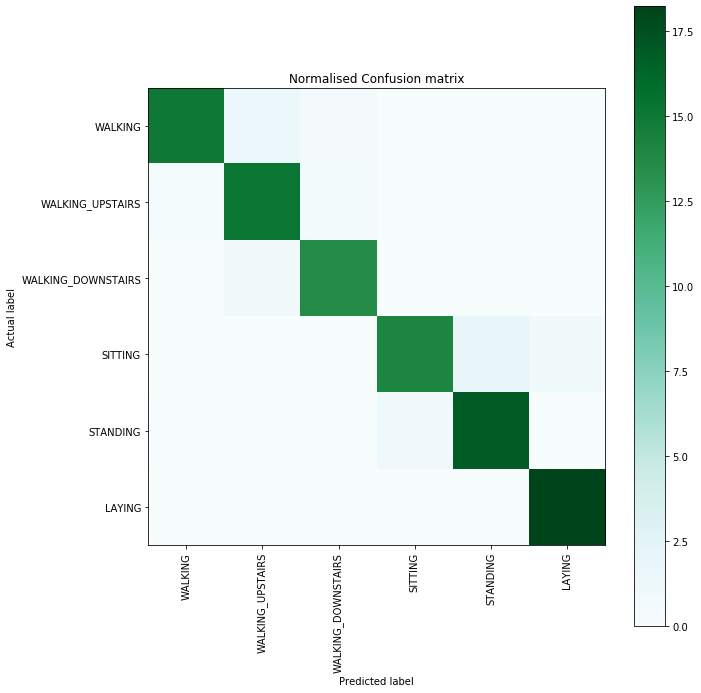

In [5]:
base_dir = '/content/gdrive/My Drive/UCI_HAR_Dataset/'

input_signals = [ "body_acc_x_", "body_acc_y_","body_acc_z_","body_gyro_x_","body_gyro_y_","body_gyro_z_", "total_acc_x_", "total_acc_y_","total_acc_z_"]

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

def x_load(signals_x_paths):
    signals_x = []

    for signal_type_path in signals_x_paths:
        with open(signal_type_path, "r") as f:
            signals_x.append(
                [np.array(serie, dtype=np.float32)
                 for serie in [row.replace('  ', ' ').strip().split(' ') for row in f]]
            )

    return np.transpose(signals_x, (1, 2, 0))

def y_load(y_path):
    with open(y_path, "r") as f:
        y = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in f
            ]],
            dtype=np.int32
        )

    y = y.reshape(-1, )
    # Substract 1 to each output class for friendly 0-based indexing
    return y - 1

# Defining paths to train and test data
train_signals_x_paths = [base_dir + "train/Inertial Signals/" + signal + "train.txt" for signal in input_signals]
test_signals_x_paths = [base_dir + "test/Inertial Signals/" + signal + "test.txt" for signal in input_signals]

train_y_path = base_dir + "train/y_train.txt"
test_y_path = base_dir + "test/y_test.txt"

train_x = x_load(train_signals_x_paths)
test_x = x_load(test_signals_x_paths)

train_y = y_load(train_y_path)
test_y = y_load(test_y_path)
train_y_matrix = np.asarray(pd.get_dummies(train_y), dtype=np.int8)
test_y_matrix = np.asarray(pd.get_dummies(test_y), dtype=np.int8)

train_y = train_y_matrix

test_y = test_y_matrix

# define parameters
seg_len = 128
num_channels = 9
num_labels = 6
batch_size = 100
learning_rate = 0.001
num_epoches = 1000
num_batches = train_x.shape[0] // batch_size
training = tf.placeholder_with_default(False, shape=())
X = tf.placeholder(tf.float32, (None, seg_len, num_channels))
Y = tf.placeholder(tf.float32, (None, num_labels))

# 1-dimensional CNN
# convolution layer 1
conv1 = tf.layers.conv1d(inputs=X, filters=32, kernel_size=2, strides=1,  padding='same', activation=tf.nn.relu)

# pooling layer 1
pool1 = tf.layers.max_pooling1d( inputs=conv1,pool_size=4, strides=2, padding='same')

# convolution layer 2
conv2 = tf.layers.conv1d( inputs=pool1, filters=64, kernel_size=2,strides=1, padding='same', activation=tf.nn.relu)

# pooling layer 2
pool2 = tf.layers.max_pooling1d(inputs=conv2,    pool_size=4,    strides=2,    padding='same')

# convolution layer 3
conv3 = tf.layers.conv1d(inputs=pool2, filters=128,  kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)

# pooling layer 3
pool3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=4, strides=2,  padding='same') 

# flat output
l_op = pool3
shape = l_op.get_shape().as_list()
flat = tf.reshape(l_op, [-1, shape[1] * shape[2]])

# fully connected layer 1
fc1 = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.tanh)
fc1 = tf.nn.dropout(fc1, keep_prob=0.5)

# fully connected layer 2
fc2 = tf.layers.dense( inputs=fc1, units=100, activation=tf.nn.tanh)
fc2 = tf.nn.dropout(fc2, keep_prob=0.5)

# fully connected layer 3
fc3 = tf.layers.dense(inputs=fc2, units=num_labels, activation=tf.nn.softmax)

output = fc3

loss_math = Y * tf.log(tf.clip_by_value(output, 1e-10, 1.0))

loss = -tf.reduce_mean(loss_math)
# define optimizer & training
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = opt.minimize(loss)
# define accuracy
correct = tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Session
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(num_epoches):
        for i in range(num_batches):
            offset = (i * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size)]
            batch_y = train_y[offset:(offset + batch_size)]
            _, c = sess.run([train_op, loss], feed_dict={X: batch_x, Y: batch_y, training: True})
        if (epoch+1) % 100 == 0:
            print("***After Epoch:", epoch+1,
                  " |Test accuracy = ", sess.run(accuracy, feed_dict={X: test_x, Y: test_y}), "****")
            pred_y = sess.run(tf.argmax(output, 1), feed_dict={X: test_x})
            cm = metrics.confusion_matrix(np.argmax(test_y, 1), pred_y,)
            
# Confusion Matrix (Convert it to dataframe and normalize it)
cmpd = pd.DataFrame(cm, columns = labels)
cmpd.index = labels
display(HTML('<b>Confusion Matrix</b>'))
display(cmpd)
# normalised to % of total test data
normalised_confusion_matrix = np.array(cm, dtype=np.float32)/np.sum(cm)*100

# Plot Results: 
width = 10
height = 10
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.BuGn
)
plt.title("Normalised Confusion matrix")
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#Close the session
sess.close()

In [13]:
#define parameters
verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
#LSTM model
model = models.Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=verbose)

print('Accuracy of LSTM model', accuracy[1]*100)   

Accuracy of LSTM model 89.82015609093995
